In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv("../data/processed/serie_mensual.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datesold  150 non-null    object 
 1   price     150 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [4]:
df['datesold'] = pd.to_datetime(df['datesold'], errors="coerce")

In [5]:
serie = (df
          .set_index('datesold')['price']
)

In [6]:
def transform_log_diff_shift(serie: pd.Series, eps: float = 1e-6):
    """
    1) Log transform para estabilizar varianza
    2) Diferenciación de orden 1 para reducir no-estacionariedad en media
    3) Shift para evitar valores negativos (opcional, pero lo aplicamos como pediste)
    
    Retorna:
      - serie_transf: serie lista para modelado/partición
      - params: diccionario con parámetros necesarios para revertir transformaciones
    """
    # Seguridad: evitar log(0) (si hubiese ceros). En precios normalmente no aplica, pero lo dejamos robusto.
    serie_pos = serie.copy()
    if (serie_pos <= 0).any():
        # Ajuste mínimo para positividad
        adj = abs(serie_pos.min()) + eps
        serie_pos = serie_pos + adj
    else:
        adj = 0.0

    # 1) Log
    serie_log = np.log(serie_pos)

    # 2) Diferencia orden 1
    serie_log_diff = serie_log.diff(1).dropna()

    # 3) Shift para no-negatividad
    min_diff = float(serie_log_diff.min())
    shift = (-min_diff) + eps if min_diff <= 0 else 0.0
    serie_ready = serie_log_diff + shift

    params = {
        "eps": eps,
        "add_to_make_positive_before_log": float(adj),
        "shift_after_diff": float(shift),
        "last_log_value_before_diff": float(serie_log.iloc[-1]),  # útil para invertir predicciones
        "last_timestamp": serie_log.index[-1],
    }

    return serie_ready, params

In [7]:
serie_modelo, tparams = transform_log_diff_shift(serie)

In [8]:
result = seasonal_decompose(serie_modelo, model='multiplicative', period=12)

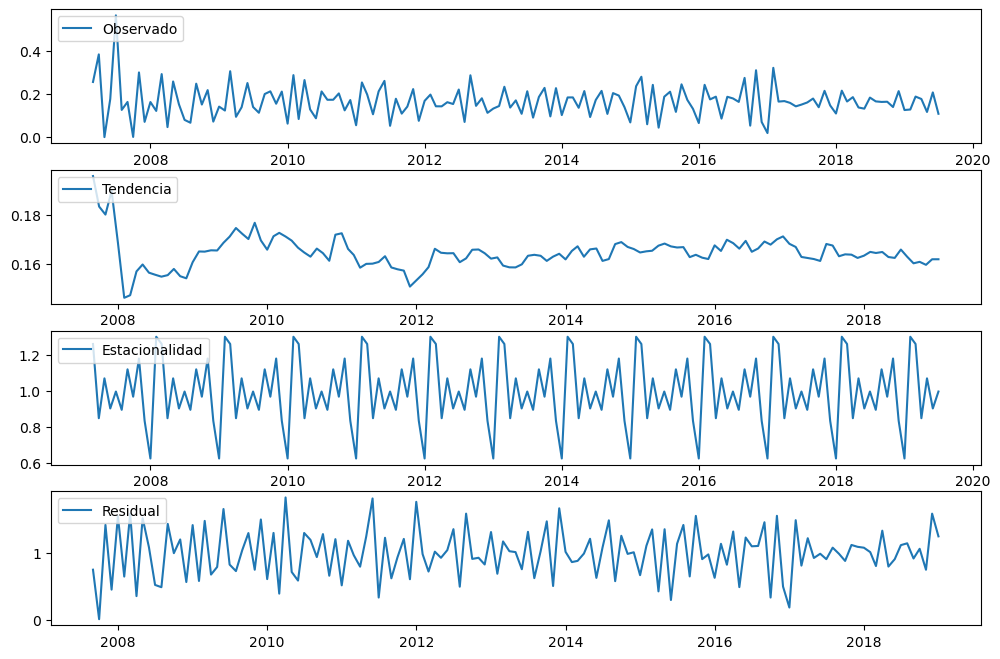

In [9]:
# Visualizar las componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.show()